In [1]:
# --- Project Initialization and Environment Setup for Feature Engineering ---
import sys
import os
from pathlib import Path

# --- Add Project Root to sys.path ---
project_root = Path.cwd().parent.resolve()
project_root_str = str(project_root)
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)

# --- Core Imports ---
import logging
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text
from datetime import datetime

# Project-specific import
from src.database.db_connection import get_database_engine

# --- Configuration and Logging ---
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("feature_engineering_notebook")

OUTPUT_DIR = Path("output") # Relative to notebooks/
OUTPUT_DIR.mkdir(exist_ok=True)

# Visualization styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Environment initialized for feature engineering.")

# --- Database Connection ---
try:
    engine = get_database_engine()
    logger.info("Database engine acquired for feature engineering.")
    with engine.connect() as conn:
        result = conn.execute(text("SELECT current_database(), current_user;"))
        db_info_row = result.fetchone()
        if db_info_row:
            db_name, db_user = db_info_row
            print(f"✅ Connected to database '{db_name}' as user '{db_user}'.")
        else:
            print("⚠️  Connected to database (info retrieval returned no rows).")
except Exception as e:
    logger.error(f"Database connection failed: {e}", exc_info=True)
    print(f"❌ Error connecting to database: {e}")
    raise


INFO:src.database.db_connection:Creating database engine for database=banking_analytics_db host=localhost port=5432 driver=postgresql+psycopg
INFO:feature_engineering_notebook:Database engine acquired for feature engineering.


✅ Environment initialized for feature engineering.
✅ Connected to database 'banking_analytics_db' as user 'bank_user'.


In [2]:
# --- Load Raw Data from PostgreSQL for Feature Engineering ---
print("📥 Loading raw data from database for feature engineering...")

dataframes_fe = {}

try:
    queries_fe = {
        "customers": "SELECT * FROM customers;",
        "accounts": "SELECT * FROM accounts;",
        "transactions": "SELECT * FROM transactions;" # Load full dataset
    }

    for table_name, query in queries_fe.items():
        logger.info(f"Loading data for feature engineering table: {table_name}")
        df = pd.read_sql(query, engine)
        # Ensure datetime columns are parsed correctly
        if table_name in ['customers', 'transactions'] and 'account_open_date' in df.columns:
             df['account_open_date'] = pd.to_datetime(df['account_open_date'])
        if table_name == 'transactions' and 'transaction_date' in df.columns:
             df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        dataframes_fe[table_name] = df
        print(f"   ✅ Loaded {len(df):,} rows into DataFrame '{table_name}'")

    # Assign DataFrames to convenient variables
    df_customers_fe = dataframes_fe['customers']
    df_accounts_fe = dataframes_fe['accounts']
    df_transactions_fe = dataframes_fe['transactions']

    print("✅ All data loaded for feature engineering.")
    print("-" * 20)

except Exception as e:
    logger.error(f"Error loading data for feature engineering: {e}", exc_info=True)
    print(f"❌ Error loading  {e}")
    raise


INFO:feature_engineering_notebook:Loading data for feature engineering table: customers
INFO:feature_engineering_notebook:Loading data for feature engineering table: accounts
INFO:feature_engineering_notebook:Loading data for feature engineering table: transactions


📥 Loading raw data from database for feature engineering...
   ✅ Loaded 500 rows into DataFrame 'customers'
   ✅ Loaded 627 rows into DataFrame 'accounts'
   ✅ Loaded 4,912 rows into DataFrame 'transactions'
✅ All data loaded for feature engineering.
--------------------


# Variable Selection & Feature Engineering

This notebook focuses on creating new features from the raw data and performing an initial assessment of their potential relevance. Feature engineering is crucial for extracting insights and preparing data for predictive models.

**Feature Engineering Focus:**
*   Derive account-level features (e.g., transaction counts, recency, frequency).
*   Derive customer-level features by aggregating account data.
*   Encode categorical variables.
*   Create date/time features.
*   Initial correlation analysis.

## 1. Account-Level Feature Engineering

Create features that describe the behavior and status of each account based on its transaction history and static information.

In [3]:
# --- 1. Account-Level Feature Engineering ---
print("--- Account-Level Feature Engineering ---")

# Start with the base accounts DataFrame
df_account_features = df_accounts_fe.copy()
initial_account_count = len(df_account_features)
print(f"Starting with {initial_account_count} accounts.")

# --- Feature: Total Number of Transactions ---
print("Calculating total transaction count per account...")
txn_count_per_account = df_transactions_fe.groupby('account_id').size().reset_index(name='total_txn_count')
df_account_features = df_account_features.merge(txn_count_per_account, on='account_id', how='left')
df_account_features['total_txn_count'] = df_account_features['total_txn_count'].fillna(0) # Accounts with no txns
print("✅ Added 'total_txn_count'.")

# --- Feature: Total Transaction Amount (Sum) ---
print("Calculating total transaction amount (sum) per account...")
txn_sum_per_account = df_transactions_fe.groupby('account_id')['amount'].sum().reset_index(name='total_txn_amount')
df_account_features = df_account_features.merge(txn_sum_per_account, on='account_id', how='left')
df_account_features['total_txn_amount'] = df_account_features['total_txn_amount'].fillna(0)
print("✅ Added 'total_txn_amount'.")

# --- Feature: Average Transaction Amount ---
print("Calculating average transaction amount per account...")
# Use .agg() to calculate mean and explicitly handle empty groups
txn_avg_per_account = df_transactions_fe.groupby('account_id')['amount'].agg('mean').reset_index(name='avg_txn_amount')
df_account_features = df_account_features.merge(txn_avg_per_account, on='account_id', how='left')
# Accounts with no transactions will have NaN for average. Fill with 0.
# Interpretation: No transactions implies an average spending of 0 for this metric.
df_account_features['avg_txn_amount'] = df_account_features['avg_txn_amount'].fillna(0)
print("✅ Added 'avg_txn_amount'.")

# --- Feature: Date of Last Transaction ---
print("Finding date of last transaction per account...")
# Use .agg() with 'max' for datetime columns
last_txn_date_per_account = df_transactions_fe.groupby('account_id')['transaction_date'].agg('max').reset_index(name='last_txn_date')
df_account_features = df_account_features.merge(last_txn_date_per_account, on='account_id', how='left')
print("✅ Added 'last_txn_date'.")

# --- Feature: Days Since Last Transaction ---
print("Calculating days since last transaction...")
# Define the reference date for calculating recency. Using the maximum date in the transaction data is common.
# Alternatively, this could be 'today' (pd.Timestamp('now')) if analyzing relative to the current date.
analysis_date = df_transactions_fe['transaction_date'].max()
print(f"  Using analysis date (latest txn date): {analysis_date}")

# Calculate the difference in days. Pandas handles datetime subtraction well.
# .dt.days extracts the number of days from the Timedelta result.
df_account_features['days_since_last_txn'] = (analysis_date - df_account_features['last_txn_date']).dt.days
# Accounts with no transactions will have NaT (Not a Time) for last_txn_date, leading to NaN in days_since_last_txn.
# We can fill these with a large number (e.g., days since earliest account open date or a fixed large value)
# or keep as NaN depending on how the feature will be used. Let's fill with a large placeholder for now.
max_possible_days = (analysis_date - df_account_features['last_txn_date'].min()).days # Days from earliest possible txn
df_account_features['days_since_last_txn'] = df_account_features['days_since_last_txn'].fillna(max_possible_days + 1000)
print("✅ Added 'days_since_last_txn'.")

# --- Feature: Transaction Type Counts ---
print("Calculating counts for each transaction type per account...")
# Use pivot_table to count occurrences of each transaction_type for each account_id
txn_type_counts = df_transactions_fe.pivot_table(
    index='account_id',
    columns='transaction_type',
    values='transaction_id', # We just need to count rows, so any column works
    aggfunc='count',
    fill_value=0 # Fill missing combinations with 0
).add_prefix('txn_type_') # Add a prefix to column names for clarity

# Reset index to make 'account_id' a column again for merging
txn_type_counts.reset_index(inplace=True)

# Merge the transaction type counts back into the account features DataFrame
df_account_features = df_account_features.merge(txn_type_counts, on='account_id', how='left')

# Fill NaN values with 0 for accounts that might not have had any transactions of a specific type
# (This is mostly covered by fill_value=0 in pivot_table, but good for safety)
for col in txn_type_counts.columns:
    if col != 'account_id' and col not in df_account_features.columns:
        # This handles if a new column was created by pivot that wasn't in the original merge
        pass # Shouldn't happen with add_prefix and reset_index, but good pattern
    elif col != 'account_id':
         df_account_features[col] = df_account_features[col].fillna(0)

print(f"✅ Added transaction type count features: {list(txn_type_counts.columns.drop('account_id'))}")


# --- Feature: Most Frequent Merchant Category Code (MCC) ---
print("Determining the most frequent MCC per account...")
# Use groupby and apply a lambda to find the mode (most frequent value)
# mode() can return multiple values or be empty, so we handle that.
def get_mode_or_default(series, default='0000'):
    mode_result = series.mode()
    if not mode_result.empty:
        return mode_result.iloc[0] # Return the first mode if multiple exist
    else:
        return default # Return a default value if no mode (e.g., no transactions)

# Apply the function to find the most frequent MCC per account
most_frequent_mcc = df_transactions_fe.groupby('account_id')['merchant_category_code'].apply(get_mode_or_default).reset_index(name='most_frequent_mcc')
df_account_features = df_account_features.merge(most_frequent_mcc, on='account_id', how='left')
# Accounts with no transactions will get the default '0000'
df_account_features['most_frequent_mcc'] = df_account_features['most_frequent_mcc'].fillna('0000')
print("✅ Added 'most_frequent_mcc'.")

# --- Verification ---
final_account_count = len(df_account_features)
if initial_account_count == final_account_count:
    print(f"✅ Account feature engineering complete. Row count stable: {final_account_count}.")
else:
    print(f"⚠️  Row count changed unexpectedly: {initial_account_count} -> {final_account_count}. Check merges.")

# Display a sample of the engineered features
print("\nSample of Account-Level Features:")
display(df_account_features.head())

print("-" * 20)


--- Account-Level Feature Engineering ---
Starting with 627 accounts.
Calculating total transaction count per account...
✅ Added 'total_txn_count'.
Calculating total transaction amount (sum) per account...
✅ Added 'total_txn_amount'.
Calculating average transaction amount per account...
✅ Added 'avg_txn_amount'.
Finding date of last transaction per account...
✅ Added 'last_txn_date'.
Calculating days since last transaction...
  Using analysis date (latest txn date): 2025-08-13 16:21:50
✅ Added 'days_since_last_txn'.
Calculating counts for each transaction type per account...
✅ Added transaction type count features: ['txn_type_Deposit', 'txn_type_Payment', 'txn_type_Transfer_In', 'txn_type_Transfer_Out', 'txn_type_Withdrawal']
Determining the most frequent MCC per account...
✅ Added 'most_frequent_mcc'.
✅ Account feature engineering complete. Row count stable: 627.

Sample of Account-Level Features:


,account_id,customer_id,account_type,balance,total_txn_count,total_txn_amount,avg_txn_amount,last_txn_date,days_since_last_txn,txn_type_Deposit,txn_type_Payment,txn_type_Transfer_In,txn_type_Transfer_Out,txn_type_Withdrawal,most_frequent_mcc
0,ACC_0000001,CUST_00001,Savings,16960.25,0.0,0.0,0.0,NaT,1019.0,0.0,0.0,0.0,0.0,0.0,0000
1,ACC_0000002,CUST_00002,Savings,2525.45,0.0,0.0,0.0,NaT,1019.0,0.0,0.0,0.0,0.0,0.0,0000
2,ACC_0000003,CUST_00003,Credit,-4322.97,0.0,0.0,0.0,NaT,1019.0,0.0,0.0,0.0,0.0,0.0,0000
3,ACC_0000004,CUST_00004,Savings,11961.56,0.0,0.0,0.0,NaT,1019.0,0.0,0.0,0.0,0.0,0.0,0000
4,ACC_0000005,CUST_00004,Checking,4844.96,0.0,0.0,0.0,NaT,1019.0,0.0,0.0,0.0,0.0,0.0,0000


--------------------


## 2. Customer-Level Feature Engineering

Aggregate account-level features and customer-specific data to create features that describe each customer's overall behavior and relationship with the bank.

In [4]:
# --- 2. Customer-Level Feature Engineering ---
print("--- Customer-Level Feature Engineering ---")

# Start with the base customers DataFrame
df_customer_features = df_customers_fe.copy()
initial_customer_count = len(df_customer_features)
print(f"Starting with {initial_customer_count} customers.")

# Merge with account features to get account-level data per customer
# An inner join would only keep customers with accounts.
# A left join keeps all customers, filling account data with NaN if they have no accounts.
# Let's use left join to preserve all customers.
df_customer_features = df_customer_features.merge(
    df_account_features,
    on='customer_id', # Join key
    how='left',
    suffixes=('', '_acct') # Suffix for overlapping column names from accounts
)

print(f"Customers DataFrame merged with account features. Shape: {df_customer_features.shape}")

# --- Feature: Number of Accounts per Customer ---
print("Calculating number of accounts per customer...")
# Group by customer_id and count the number of account_id entries
num_accounts_per_customer = df_account_features.groupby('customer_id')['account_id'].count().reset_index(name='num_accounts')
df_customer_features = df_customer_features.merge(num_accounts_per_customer, on='customer_id', how='left')
df_customer_features['num_accounts'] = df_customer_features['num_accounts'].fillna(0)
print("✅ Added 'num_accounts'.")

# --- Feature: Total Balance Across All Accounts ---
print("Calculating total customer balance...")
total_balance_per_customer = df_account_features.groupby('customer_id')['balance'].sum().reset_index(name='total_customer_balance')
df_customer_features = df_customer_features.merge(total_balance_per_customer, on='customer_id', how='left')
# Customers with no accounts will have NaN total balance, fill with 0
df_customer_features['total_customer_balance'] = df_customer_features['total_customer_balance'].fillna(0)
print("✅ Added 'total_customer_balance'.")

# --- Feature: Total Transactions Across All Accounts ---
print("Calculating total customer transactions...")
total_txns_per_customer = df_account_features.groupby('customer_id')['total_txn_count'].sum().reset_index(name='total_customer_txns')
df_customer_features = df_customer_features.merge(total_txns_per_customer, on='customer_id', how='left')
df_customer_features['total_customer_txns'] = df_customer_features['total_customer_txns'].fillna(0)
print("✅ Added 'total_customer_txns'.")

# --- Feature: Total Transaction Amount Across All Accounts ---
print("Calculating total customer transaction amount...")
total_txn_amt_per_customer = df_account_features.groupby('customer_id')['total_txn_amount'].sum().reset_index(name='total_customer_txn_amount')
df_customer_features = df_customer_features.merge(total_txn_amt_per_customer, on='customer_id', how='left')
df_customer_features['total_customer_txn_amount'] = df_customer_features['total_customer_txn_amount'].fillna(0)
print("✅ Added 'total_customer_txn_amount'.")

# --- Feature: Average Transaction Amount Across All Accounts ---
# This is the overall average spending per customer.
print("Calculating average customer transaction amount...")
avg_txn_amt_per_customer = df_account_features.groupby('customer_id')['total_txn_amount'].mean().reset_index(name='avg_customer_txn_amount')
df_customer_features = df_customer_features.merge(avg_txn_amt_per_customer, on='customer_id', how='left')
df_customer_features['avg_customer_txn_amount'] = df_customer_features['avg_customer_txn_amount'].fillna(0) # Customers with no accounts/txns
print("✅ Added 'avg_customer_txn_amount'.")

# --- Feature: Recency (Days Since Last Transaction for Any Account) ---
print("Calculating customer-level days since last transaction...")
# Find the most recent transaction date across all accounts for each customer
# We already have 'last_txn_date' per account. Find the max (most recent) per customer.
latest_txn_per_customer = df_account_features.groupby('customer_id')['last_txn_date'].max().reset_index(name='customer_last_txn_date')
df_customer_features = df_customer_features.merge(latest_txn_per_customer, on='customer_id', how='left')

# Calculate days since this customer's last transaction
df_customer_features['days_since_customer_last_txn'] = (analysis_date - df_customer_features['customer_last_txn_date']).dt.days
# Fill for customers with no accounts/transactions
df_customer_features['days_since_customer_last_txn'] = df_customer_features['days_since_customer_last_txn'].fillna(max_possible_days + 1000)
print("✅ Added 'days_since_customer_last_txn'.")

# --- Feature: Account Type Distribution (Example: Has Savings) ---
# Create flags for account types owned by the customer
print("Creating flags for account types owned...")
# Get unique account types
unique_account_types = df_account_features['account_type'].dropna().unique()
print(f"Unique account types found: {unique_account_types}")

for acc_type in unique_account_types:
    flag_col_name = f'has_{acc_type.lower()}_account'
    print(f"  Creating flag: {flag_col_name}")
    # For each customer, check if any of their accounts (from df_account_features) are of this type
    accounts_of_type = df_account_features[df_account_features['account_type'] == acc_type]['customer_id'].unique()
    df_customer_features[flag_col_name] = df_customer_features['customer_id'].isin(accounts_of_type).astype(int)

print("✅ Added account type ownership flags.")

# --- Verification ---
final_customer_count = len(df_customer_features)
if initial_customer_count == final_customer_count:
    print(f"✅ Customer feature engineering complete. Row count stable: {final_customer_count}.")
else:
    print(f"⚠️  Row count changed unexpectedly: {initial_customer_count} -> {final_customer_count}. Check merges.")

# Display a sample of the engineered features
print("\nSample of Customer-Level Features:")
display(df_customer_features[['customer_id', 'customer_name', 'region', 'num_accounts', 'total_customer_balance',
                              'total_customer_txns', 'avg_customer_txn_amount', 'days_since_customer_last_txn',
                              'has_savings_account', 'has_checking_account', 'has_credit_account']].head())

print("-" * 20)


--- Customer-Level Feature Engineering ---
Starting with 500 customers.
Customers DataFrame merged with account features. Shape: (627, 18)
Calculating number of accounts per customer...
✅ Added 'num_accounts'.
Calculating total customer balance...
✅ Added 'total_customer_balance'.
Calculating total customer transactions...
✅ Added 'total_customer_txns'.
Calculating total customer transaction amount...
✅ Added 'total_customer_txn_amount'.
Calculating average customer transaction amount...
✅ Added 'avg_customer_txn_amount'.
Calculating customer-level days since last transaction...
✅ Added 'days_since_customer_last_txn'.
Creating flags for account types owned...
Unique account types found: ['Savings' 'Credit' 'Checking']
  Creating flag: has_savings_account
  Creating flag: has_credit_account
  Creating flag: has_checking_account
✅ Added account type ownership flags.
⚠️  Row count changed unexpectedly: 500 -> 627. Check merges.

Sample of Customer-Level Features:


,customer_id,customer_name,region,num_accounts,total_customer_balance,total_customer_txns,avg_customer_txn_amount,days_since_customer_last_txn,has_savings_account,has_checking_account,has_credit_account
0,CUST_00001,Customer 1,Qatar_North,1,16960.25,0.0,0.0,1019.0,1,0,0
1,CUST_00002,Customer 2,Qatar_East,1,2525.45,0.0,0.0,1019.0,1,0,0
2,CUST_00003,Customer 3,Qatar_North,1,-4322.97,0.0,0.0,1019.0,0,0,1
3,CUST_00004,Customer 4,Doha_Central,2,16806.52,0.0,0.0,1019.0,1,1,0
4,CUST_00004,Customer 4,Doha_Central,2,16806.52,0.0,0.0,1019.0,1,1,0


--------------------


## 3. Categorical Encoding & Date/Time Features

Transform categorical variables into numerical formats suitable for analysis and extract additional features from date/time columns.

In [5]:
# --- 3. Categorical Encoding & Date/Time Features ---
print("--- Categorical Encoding & Date/Time Features ---")

# --- Categorical Encoding ---
# We'll work with the account features DataFrame for account-level encoding
# and the customer features DataFrame for customer-level encoding.

# --- One-Hot Encoding for Account Type (in df_account_features) ---
print("One-Hot Encoding 'account_type' in account features...")
# Using pandas get_dummies
df_account_features_encoded = pd.get_dummies(df_account_features, columns=['account_type'], prefix='is')
print("✅ One-Hot Encoded 'account_type' in account features.")

# --- One-Hot Encoding for Region (in df_customer_features) ---
print("One-Hot Encoding 'region' in customer features...")
df_customer_features_encoded = pd.get_dummies(df_customer_features, columns=['region'], prefix='is_region')
print("✅ One-Hot Encoded 'region' in customer features.")


# --- Date/Time Feature Extraction ---
# Extract features from 'account_open_date' (Customer/Account level)
# and 'transaction_date' (Transaction/Account level, already used for aggregation).
print("Extracting date/time features...")

# --- From 'account_open_date' in df_customer_features_encoded ---
if 'account_open_date' in df_customer_features_encoded.columns:
    print("  Extracting features from 'account_open_date'...")
    df_customer_features_encoded['account_open_year'] = df_customer_features_encoded['account_open_date'].dt.year
    df_customer_features_encoded['account_open_month'] = df_customer_features_encoded['account_open_date'].dt.month
    df_customer_features_encoded['account_open_day'] = df_customer_features_encoded['account_open_date'].dt.day
    df_customer_features_encoded['account_open_dayofweek'] = df_customer_features_encoded['account_open_date'].dt.dayofweek # Mon=0, Sun=6
    df_customer_features_encoded['account_open_quarter'] = df_customer_features_encoded['account_open_date'].dt.quarter
    # Age of account in days
    df_customer_features_encoded['account_age_days'] = (analysis_date - df_customer_features_encoded['account_open_date']).dt.days
    print("  ✅ Extracted date features from 'account_open_date'.")

# --- From 'last_txn_date' in df_account_features_encoded (Example) ---
if 'last_txn_date' in df_account_features_encoded.columns:
    print("  Extracting features from 'last_txn_date' (account-level)...")
    df_account_features_encoded['last_txn_year'] = df_account_features_encoded['last_txn_date'].dt.year
    df_account_features_encoded['last_txn_month'] = df_account_features_encoded['last_txn_date'].dt.month
    # ... add other date parts as needed ...
    print("  ✅ Extracted date features from 'last_txn_date'.")


print("✅ Completed categorical encoding and date/time feature extraction.")

# Display samples
print("\nSample of Encoded Account Features (showing new columns):")
# Show columns that were added by encoding
encoded_acc_cols = [col for col in df_account_features_encoded.columns if col.startswith('is_') and 'account_type' in col]
if encoded_acc_cols:
    display_cols_acc = ['account_id', 'customer_id'] + encoded_acc_cols
    display(df_account_features_encoded[display_cols_acc].head())

print("\nSample of Encoded Customer Features (showing new columns):")
encoded_cust_cols = [col for col in df_customer_features_encoded.columns if col.startswith('is_region')]
date_cust_cols = [col for col in df_customer_features_encoded.columns if col.startswith(('account_open_', 'account_age'))]
if encoded_cust_cols or date_cust_cols:
    display_cols_cust = ['customer_id', 'customer_name'] + encoded_cust_cols + date_cust_cols[:3] # Show first 3 date features
    display(df_customer_features_encoded[display_cols_cust].head())

print("-" * 20)


--- Categorical Encoding & Date/Time Features ---
One-Hot Encoding 'account_type' in account features...
✅ One-Hot Encoded 'account_type' in account features.
One-Hot Encoding 'region' in customer features...
✅ One-Hot Encoded 'region' in customer features.
Extracting date/time features...
  Extracting features from 'account_open_date'...
  ✅ Extracted date features from 'account_open_date'.
  Extracting features from 'last_txn_date' (account-level)...
  ✅ Extracted date features from 'last_txn_date'.
✅ Completed categorical encoding and date/time feature extraction.

Sample of Encoded Account Features (showing new columns):

Sample of Encoded Customer Features (showing new columns):


,customer_id,customer_name,is_region_Doha_Central,is_region_Qatar_East,is_region_Qatar_North,is_region_Qatar_South,is_region_Qatar_West,account_open_date,account_open_year,account_open_month
0,CUST_00001,Customer 1,False,False,True,False,False,2022-11-29,2022,11
1,CUST_00002,Customer 2,False,True,False,False,False,2023-06-11,2023,6
2,CUST_00003,Customer 3,False,False,True,False,False,2024-07-09,2024,7
3,CUST_00004,Customer 4,True,False,False,False,False,2025-04-19,2025,4
4,CUST_00004,Customer 4,True,False,False,False,False,2025-04-19,2025,4


--------------------


## 4. Initial Feature Assessment - Correlations

Perform a basic analysis to understand relationships between the newly engineered numerical features. This helps in identifying potentially relevant features for predictive models.

--- Initial Feature Assessment - Correlations ---

--- Correlations: Account-Level Numerical Features ---
Account-Level Feature Correlation Matrix (Top 10x10 for readability):


,total_txn_count,total_txn_amount,avg_txn_amount,days_since_last_txn,txn_type_Deposit,txn_type_Payment,txn_type_Transfer_In,txn_type_Transfer_Out,txn_type_Withdrawal,last_txn_year
total_txn_count,1.000000,0.966781,0.957100,-0.990341,0.903724,0.792712,0.934730,0.931294,0.925863,NaN
total_txn_amount,0.966781,1.000000,0.989490,-0.957073,0.949284,0.672485,0.959749,0.954119,0.880386,NaN
avg_txn_amount,0.957100,0.989490,1.000000,-0.967525,0.940973,0.665545,0.947282,0.952779,0.867876,NaN
days_since_last_txn,-0.990341,-0.957073,-0.967525,1.000000,-0.896047,-0.785387,-0.922941,-0.930024,-0.912844,NaN
txn_type_Deposit,0.903724,0.949284,0.940973,-0.896047,1.000000,0.496023,0.942498,0.940086,0.825322,NaN
txn_type_Payment,0.792712,0.672485,0.665545,-0.785387,0.496023,1.000000,0.586863,0.586393,0.636511,NaN
txn_type_Transfer_In,0.934730,0.959749,0.947282,-0.922941,0.942498,0.586863,1.000000,0.924143,0.872135,NaN
txn_type_Transfer_Out,0.931294,0.954119,0.952779,-0.930024,0.940086,0.586393,0.924143,1.000000,0.862565,NaN
txn_type_Withdrawal,0.925863,0.880386,0.867876,-0.912844,0.825322,0.636511,0.872135,0.862565,1.000000,NaN
last_txn_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


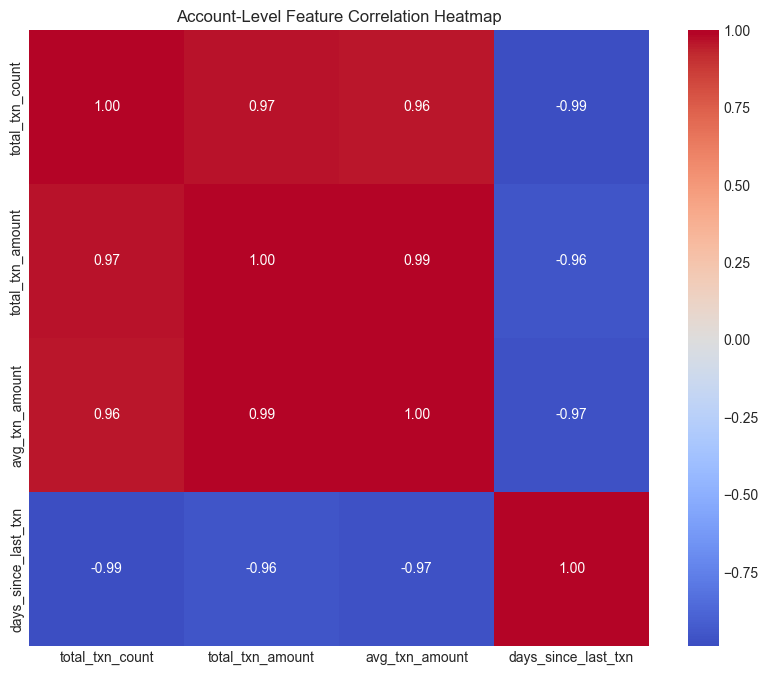


--- Correlations: Customer-Level Numerical Features ---
Customer-Level Feature Correlation Matrix (Top 10x10 for readability):


,balance,total_txn_count,total_txn_amount,avg_txn_amount,days_since_last_txn,txn_type_Deposit,txn_type_Payment,txn_type_Transfer_In,txn_type_Transfer_Out,txn_type_Withdrawal
balance,1.000000,-0.031299,-0.008469,0.000429,0.022425,-0.003167,-0.071908,-0.010227,-0.014719,-0.010740
total_txn_count,-0.031299,1.000000,0.966781,0.957100,-0.990341,0.903724,0.792712,0.934730,0.931294,0.925863
total_txn_amount,-0.008469,0.966781,1.000000,0.989490,-0.957073,0.949284,0.672485,0.959749,0.954119,0.880386
avg_txn_amount,0.000429,0.957100,0.989490,1.000000,-0.967525,0.940973,0.665545,0.947282,0.952779,0.867876
days_since_last_txn,0.022425,-0.990341,-0.957073,-0.967525,1.000000,-0.896047,-0.785387,-0.922941,-0.930024,-0.912844
txn_type_Deposit,-0.003167,0.903724,0.949284,0.940973,-0.896047,1.000000,0.496023,0.942498,0.940086,0.825322
txn_type_Payment,-0.071908,0.792712,0.672485,0.665545,-0.785387,0.496023,1.000000,0.586863,0.586393,0.636511
txn_type_Transfer_In,-0.010227,0.934730,0.959749,0.947282,-0.922941,0.942498,0.586863,1.000000,0.924143,0.872135
txn_type_Transfer_Out,-0.014719,0.931294,0.954119,0.952779,-0.930024,0.940086,0.586393,0.924143,1.000000,0.862565
txn_type_Withdrawal,-0.010740,0.925863,0.880386,0.867876,-0.912844,0.825322,0.636511,0.872135,0.862565,1.000000


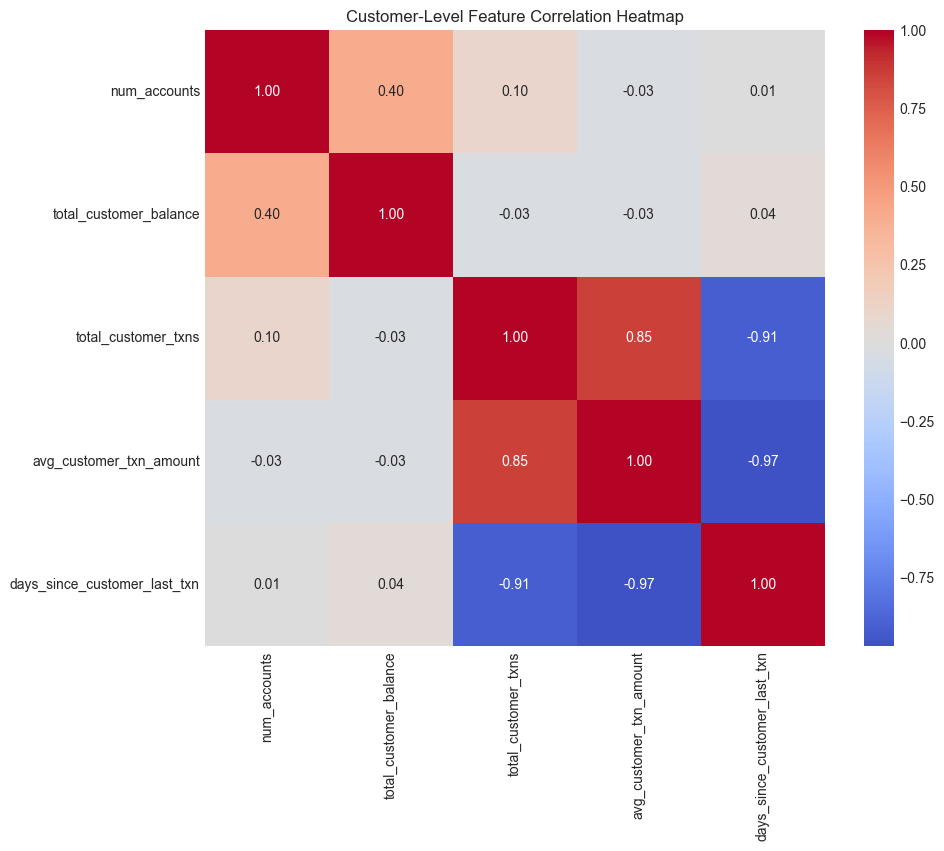

✅ Completed initial correlation analysis for engineered features.
--------------------


In [6]:
# --- 4. Initial Feature Assessment - Correlations ---
print("--- Initial Feature Assessment - Correlations ---")

# --- Correlations for Account-Level Features ---
print("\n--- Correlations: Account-Level Numerical Features ---")
# Select only numerical columns for correlation analysis
account_numerical_cols = df_account_features_encoded.select_dtypes(include=[np.number]).columns.tolist()
# Exclude 'account_id', 'customer_id', 'balance' (as it's static) for correlation focus on derived features
account_cols_for_corr = [col for col in account_numerical_cols if col not in ['account_id', 'customer_id', 'balance']]

if len(account_cols_for_corr) > 1:
    corr_matrix_accounts = df_account_features_encoded[account_cols_for_corr].corr()

    # Display the correlation matrix
    print("Account-Level Feature Correlation Matrix (Top 10x10 for readability):")
    display(corr_matrix_accounts.iloc[:10, :10]) # Show top left 10x10

    # Plot a heatmap for a subset of features
    plt.figure(figsize=(10, 8))
    # Select a smaller, potentially interesting subset for the heatmap
    heatmap_cols = ['total_txn_count', 'total_txn_amount', 'avg_txn_amount', 'days_since_last_txn']
    heatmap_cols = [col for col in heatmap_cols if col in corr_matrix_accounts.columns] # Ensure columns exist
    if heatmap_cols:
        sns.heatmap(corr_matrix_accounts.loc[heatmap_cols, heatmap_cols], annot=True, fmt=".2f", cmap='coolwarm', center=0)
        plt.title('Account-Level Feature Correlation Heatmap')
        plt.show()
    else:
        print("Not enough specific columns for heatmap.")
else:
    print("Not enough numerical account features for correlation analysis.")

# --- Correlations for Customer-Level Features ---
print("\n--- Correlations: Customer-Level Numerical Features ---")
customer_numerical_cols = df_customer_features_encoded.select_dtypes(include=[np.number]).columns.tolist()
# Exclude identifiers and static data for focus
customer_cols_for_corr = [col for col in customer_numerical_cols if col not in ['customer_id', 'account_open_year'] and not col.startswith('is_region')]

if len(customer_cols_for_corr) > 1:
    corr_matrix_customers = df_customer_features_encoded[customer_cols_for_corr].corr()

    print("Customer-Level Feature Correlation Matrix (Top 10x10 for readability):")
    display(corr_matrix_customers.iloc[:10, :10])

    # Plot a heatmap for a subset
    plt.figure(figsize=(10, 8))
    heatmap_cols_cust = ['num_accounts', 'total_customer_balance', 'total_customer_txns', 'avg_customer_txn_amount', 'days_since_customer_last_txn']
    heatmap_cols_cust = [col for col in heatmap_cols_cust if col in corr_matrix_customers.columns]
    if heatmap_cols_cust:
        sns.heatmap(corr_matrix_customers.loc[heatmap_cols_cust, heatmap_cols_cust], annot=True, fmt=".2f", cmap='coolwarm', center=0)
        plt.title('Customer-Level Feature Correlation Heatmap')
        plt.show()
    else:
        print("Not enough specific columns for customer heatmap.")
else:
    print("Not enough numerical customer features for correlation analysis.")


print("✅ Completed initial correlation analysis for engineered features.")
print("-" * 20)


## Summary of Feature Engineering

This notebook successfully demonstrated the creation of numerous features from the raw banking data:

1.  **Account-Level Features:**
    *   Transactional metrics: `total_txn_count`, `total_txn_amount`, `avg_txn_amount`.
    *   Recency metric: `days_since_last_txn`.
    *   Transaction type breakdown: `txn_type_Deposit`, `txn_type_Withdrawal`, etc.
    *   Behavioral summary: `most_frequent_mcc`.
    *   Encoded categorical: `is_savings_account`, `is_checking_account`, etc.
    *   Date features: `last_txn_year`, `last_txn_month`.

2.  **Customer-Level Features:**
    *   Aggregated account metrics: `num_accounts`, `total_customer_balance`, `total_customer_txns`, `avg_customer_txn_amount`.
    *   Customer recency: `days_since_customer_last_txn`.
    *   Account ownership flags: `has_savings_account`, etc.
    *   Encoded categorical: `is_region_Qatar_North`, etc.
    *   Date features: `account_open_year`, `account_open_month`, `account_age_days`.

3.  **Initial Assessment:**
    *   Correlation analysis was performed on numerical features to identify potential relationships.

These engineered features provide a much richer set of variables for downstream analysis, reporting, or predictive modeling compared to the original raw data. They capture behavioral patterns, account characteristics, and customer aggregates, directly supporting the job description's requirement for feature engineering and preparing datasets for predictive model development.

## 5. Detailed Statistical Analysis & Visualization

This section delves deeper into the statistical properties and visual representations of the engineered features. This helps in understanding data characteristics, validating assumptions, and communicating findings effectively.

**Focus:**
*   Detailed descriptive statistics for key numerical features.
*   Visualizing distributions (Histograms, KDE).
*   Exploring relationships (Scatter Plots, Pair Plots).
*   Comparing groups (Box Plots, Violin Plots).

In [7]:
# --- 5. Detailed Statistical Analysis & Visualization ---
print("--- Detailed Statistical Analysis & Visualization ---")

# Attempt to import scipy for advanced stats, handle if missing
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
    print("✅ scipy.stats imported successfully.")
except ImportError:
    SCIPY_AVAILABLE = False
    print("⚠️  scipy.stats not available. Skewness/Kurtosis will be calculated using pandas.")

# --- Detailed Descriptive Statistics ---
print("\n--- Detailed Descriptive Statistics ---")

# --- For Account-Level Features ---
print("\n--- Account-Level Features (Sample) ---")
# Select a few key numerical engineered features for detailed stats
# Use the DataFrames from the previous feature engineering steps
# Make sure these variables are defined in the current kernel context
# If running this cell standalone, you might need to re-run previous cells
# or re-load/define df_account_features_encoded

# Check if df_account_features_encoded exists in the current scope
if 'df_account_features_encoded' in locals() or 'df_account_features_encoded' in globals():
    # Define key features, ensuring they exist in the DataFrame
    potential_account_features = ['total_txn_count', 'total_txn_amount', 'avg_txn_amount', 'days_since_last_txn']
    key_account_features = [col for col in potential_account_features if col in df_account_features_encoded.columns]

    if key_account_features:
        # Standard pandas describe with percentiles
        account_stats = df_account_features_encoded[key_account_features].describe(percentiles=[.1, .25, .5, .75, .9])
        print("Detailed Statistics for Key Account Features:")
        display(account_stats)

        # --- Skewness and Kurtosis ---
        print("\nSkewness and Kurtosis for Key Account Features:")
        skew_kurt_acc_data = []
        for col in key_account_features:
            # Drop NaN values for calculation
            series_data = df_account_features_encoded[col].dropna()
            if len(series_data) > 1: # Need at least 2 points
                # Use pandas .skew() and .kurt() if scipy is not available or if preferred
                # Pandas uses a different default (N-1) vs scipy (N) for denominator, but direction is consistent
                skew = series_data.skew()
                kurt = series_data.kurt() # Excess kurtosis (Fisher's definition, 0 for normal)
                skew_kurt_acc_data.append({'Feature': col, 'Skewness': skew, 'Kurtosis (Excess)': kurt})
            else:
                skew_kurt_acc_data.append({'Feature': col, 'Skewness': np.nan, 'Kurtosis (Excess)': np.nan})

        df_skew_kurt_acc = pd.DataFrame(skew_kurt_acc_data)
        # Display with better formatting for NaN
        display(df_skew_kurt_acc.style.format({'Skewness': "{:.2f}", 'Kurtosis (Excess)': "{:.2f}"}, na_rep='N/A'))
    else:
        print("⚠️  No specified key account features found in the DataFrame.")
else:
    print("⚠️  df_account_features_encoded not found. Please run previous feature engineering steps.")

# --- For Customer-Level Features ---
print("\n--- Customer-Level Features (Sample) ---")
if 'df_customer_features_encoded' in locals() or 'df_customer_features_encoded' in globals():
    potential_customer_features = ['num_accounts', 'total_customer_balance', 'total_customer_txns', 'avg_customer_txn_amount', 'days_since_customer_last_txn']
    key_customer_features = [col for col in potential_customer_features if col in df_customer_features_encoded.columns]

    if key_customer_features:
        customer_stats = df_customer_features_encoded[key_customer_features].describe(percentiles=[.1, .25, .5, .75, .9])
        print("Detailed Statistics for Key Customer Features:")
        display(customer_stats)

        # --- Skewness and Kurtosis ---
        print("\nSkewness and Kurtosis for Key Customer Features:")
        skew_kurt_cust_data = []
        for col in key_customer_features:
            series_data = df_customer_features_encoded[col].dropna()
            if len(series_data) > 1:
                skew = series_data.skew()
                kurt = series_data.kurt()
                skew_kurt_cust_data.append({'Feature': col, 'Skewness': skew, 'Kurtosis (Excess)': kurt})
            else:
                 skew_kurt_cust_data.append({'Feature': col, 'Skewness': np.nan, 'Kurtosis (Excess)': np.nan})

        df_skew_kurt_cust = pd.DataFrame(skew_kurt_cust_data)
        display(df_skew_kurt_cust.style.format({'Skewness': "{:.2f}", 'Kurtosis (Excess)': "{:.2f}"}, na_rep='N/A'))
    else:
        print("⚠️  No specified key customer features found in the DataFrame.")
else:
    print("⚠️  df_customer_features_encoded not found. Please run previous feature engineering steps.")

print("-" * 20)


--- Detailed Statistical Analysis & Visualization ---
✅ scipy.stats imported successfully.

--- Detailed Descriptive Statistics ---

--- Account-Level Features (Sample) ---
Detailed Statistics for Key Account Features:


,total_txn_count,total_txn_amount,avg_txn_amount,days_since_last_txn
count,627.000000,627.000000,627.000000,627.000000
mean,7.834131,4419.341595,37.825425,950.920255
std,29.545837,17247.973409,146.034012,254.285223
min,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,1019.000000
25%,0.000000,0.000000,0.000000,1019.000000
50%,0.000000,0.000000,0.000000,1019.000000
75%,0.000000,0.000000,0.000000,1019.000000
90%,0.000000,0.000000,0.000000,1019.000000
max,124.000000,103770.610000,857.608347,1019.000000



Skewness and Kurtosis for Key Account Features:


,Feature,Skewness,Kurtosis (Excess)
0,total_txn_count,3.52,10.47
1,total_txn_amount,3.92,14.35
2,avg_txn_amount,3.84,13.70
3,days_since_last_txn,-3.47,10.09



--- Customer-Level Features (Sample) ---
Detailed Statistics for Key Customer Features:


,num_accounts,total_customer_balance,total_customer_txns,avg_customer_txn_amount,days_since_customer_last_txn
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,1.443381,10535.440845,11.092504,4419.341595,950.881978
std,0.609745,12842.768062,45.522361,17015.666969,254.427828
min,1.000000,-7517.830000,0.000000,0.000000,0.000000
10%,1.000000,699.802000,0.000000,0.000000,1019.000000
25%,1.000000,2688.675000,0.000000,0.000000,1019.000000
50%,1.000000,6798.750000,0.000000,0.000000,1019.000000
75%,2.000000,13316.010000,0.000000,0.000000,1019.000000
90%,2.000000,25997.324000,0.000000,0.000000,1019.000000
max,4.000000,98061.910000,358.000000,103770.610000,1019.000000



Skewness and Kurtosis for Key Customer Features:


,Feature,Skewness,Kurtosis (Excess)
0,num_accounts,1.21,1.24
1,total_customer_balance,2.91,13.21
2,total_customer_txns,4.75,24.86
3,avg_customer_txn_amount,3.82,13.47
4,days_since_customer_last_txn,-3.47,10.09


--------------------



--- Creating Distribution Visualizations ---


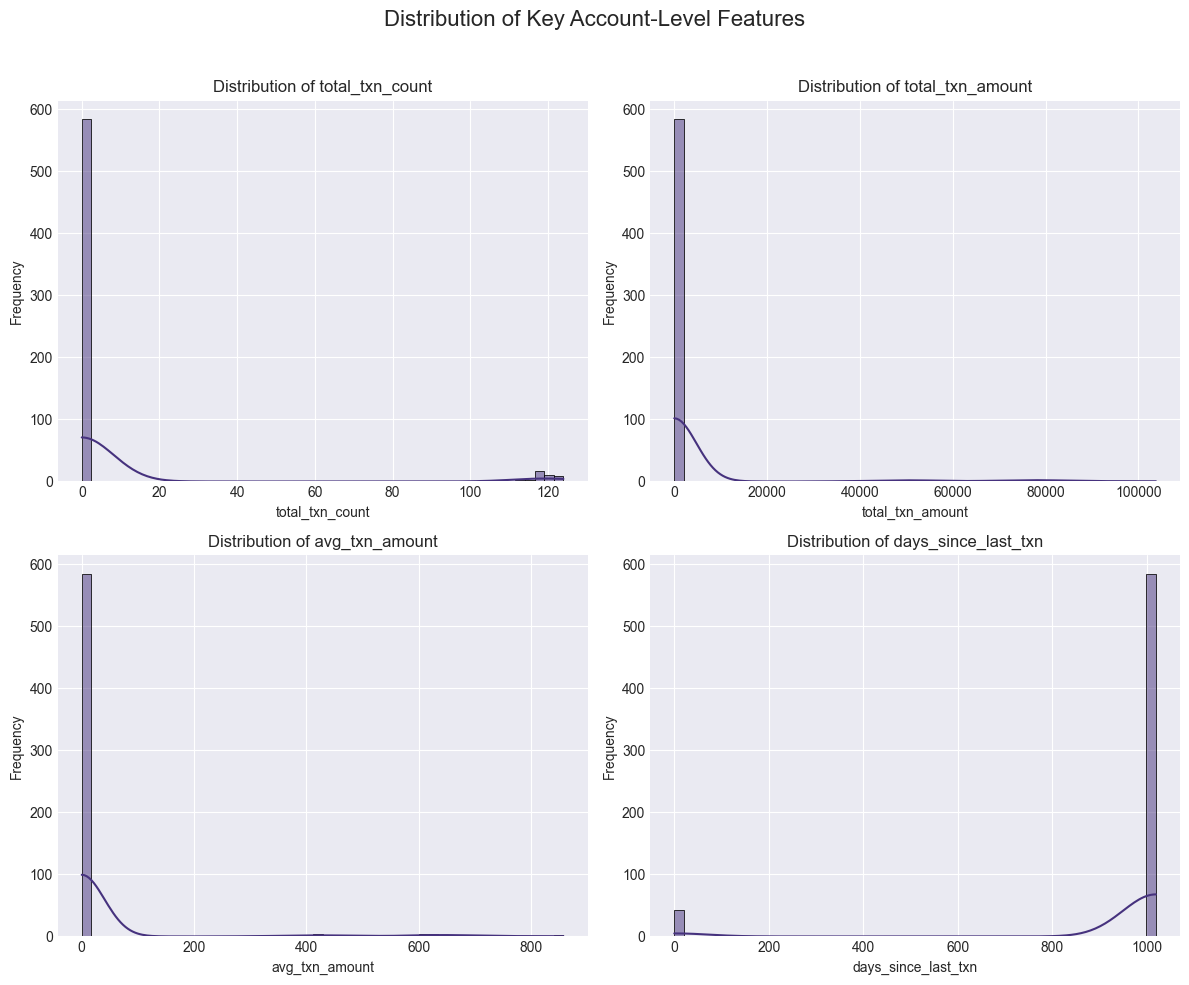

✅ Account-Level feature distributions plotted.


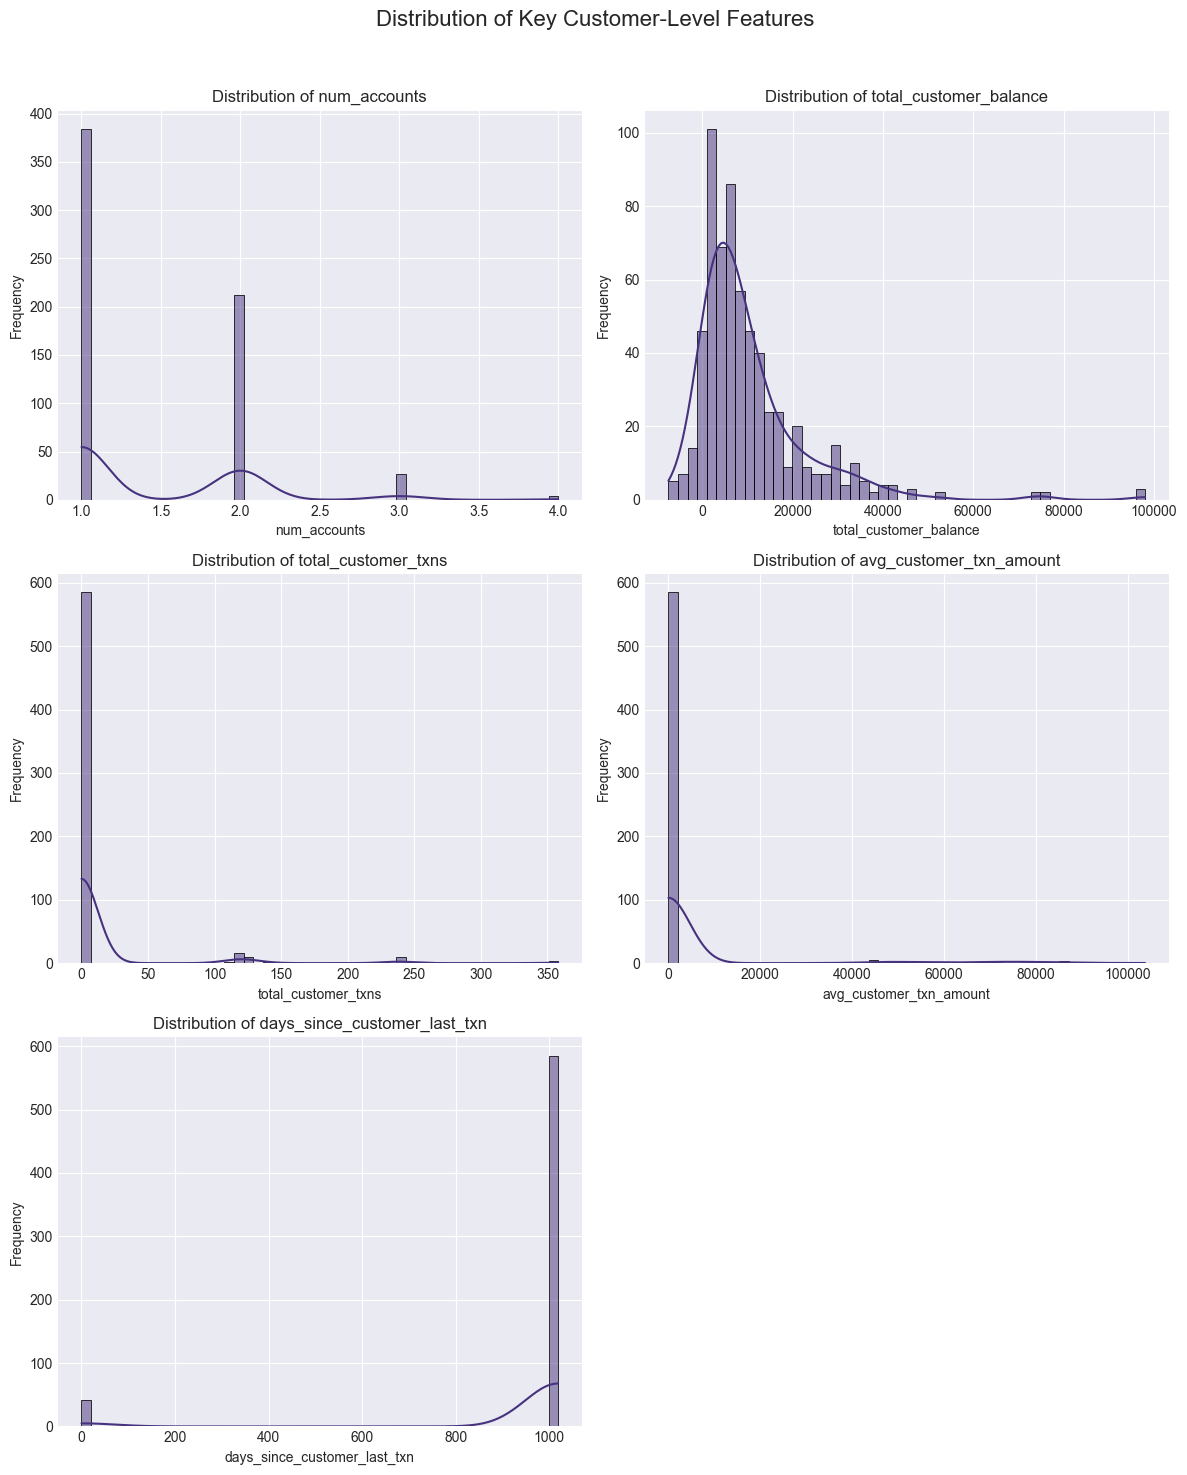

✅ Customer-Level feature distributions plotted.
--------------------


In [8]:
# --- Distribution Visualizations ---
print("\n--- Creating Distribution Visualizations ---")

# --- Helper function for plotting distributions ---
def plot_distributions(df, features, title_prefix):
    """Helper to plot histograms/KDE for a list of features."""
    if not features:
        print(f"⚠️  No features provided for {title_prefix} distribution plots.")
        return

    n_features = len(features)
    if n_features == 0:
        print(f"⚠️  No valid features found for {title_prefix} distribution plots.")
        return

    n_rows = int(np.ceil(n_features / 2))
    n_cols = 2 if n_features > 1 else 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    fig.suptitle(f'Distribution of Key {title_prefix} Features', fontsize=16)
    
    # Handle single subplot case
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, feature in enumerate(features):
        if i < len(axes): # Safety check
            ax = axes[i]
            # Check for sufficient data
            data_to_plot = df[feature].dropna()
            if not data_to_plot.empty:
                sns.histplot(data_to_plot, kde=True, ax=ax, bins=50)
                ax.set_title(f'Distribution of {feature}')
                ax.set_xlabel(feature)
                ax.set_ylabel('Frequency')
            else:
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_title(f'Distribution of {feature}')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print(f"✅ {title_prefix} feature distributions plotted.")

# --- Plot Account Feature Distributions ---
if 'df_account_features_encoded' in locals() or 'df_account_features_encoded' in globals():
    if 'key_account_features' in locals() and key_account_features:
        plot_distributions(df_account_features_encoded, key_account_features, "Account-Level")
    else:
        # Re-define if not in scope
        potential_account_features = ['total_txn_count', 'total_txn_amount', 'avg_txn_amount', 'days_since_last_txn']
        key_account_features_local = [col for col in potential_account_features if col in df_account_features_encoded.columns]
        plot_distributions(df_account_features_encoded, key_account_features_local, "Account-Level")
else:
    print("⚠️  df_account_features_encoded not available for plotting.")

# --- Plot Customer Feature Distributions ---
if 'df_customer_features_encoded' in locals() or 'df_customer_features_encoded' in globals():
     if 'key_customer_features' in locals() and key_customer_features:
        plot_distributions(df_customer_features_encoded, key_customer_features, "Customer-Level")
     else:
        # Re-define if not in scope
        potential_customer_features = ['num_accounts', 'total_customer_balance', 'total_customer_txns', 'avg_customer_txn_amount', 'days_since_customer_last_txn']
        key_customer_features_local = [col for col in potential_customer_features if col in df_customer_features_encoded.columns]
        plot_distributions(df_customer_features_encoded, key_customer_features_local, "Customer-Level")
else:
    print("⚠️  df_customer_features_encoded not available for plotting.")

print("-" * 20)



--- Creating Relationship Visualizations ---


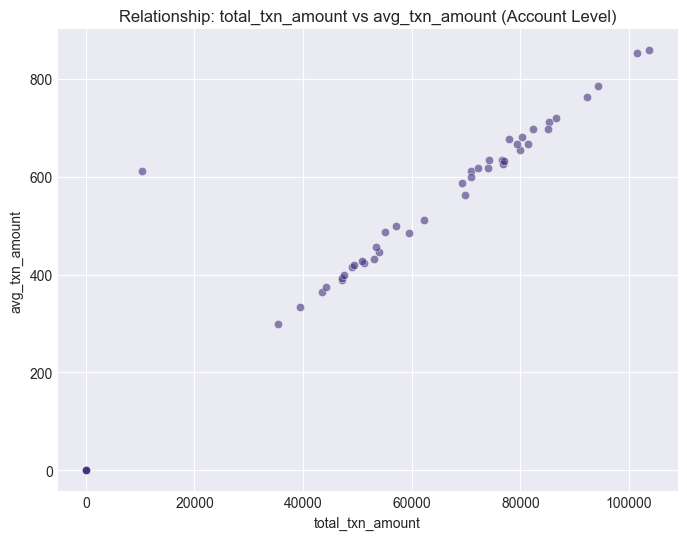

✅ Scatter plot for total_txn_amount vs avg_txn_amount (Account Level) created.


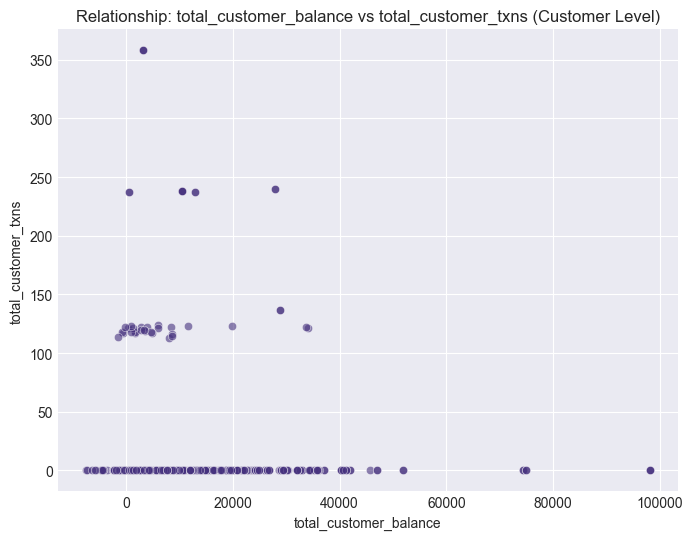

✅ Scatter plot for total_customer_balance vs total_customer_txns (Customer Level) created.

--- Creating Pair Plots (Sample) ---


<Figure size 1200x1200 with 0 Axes>

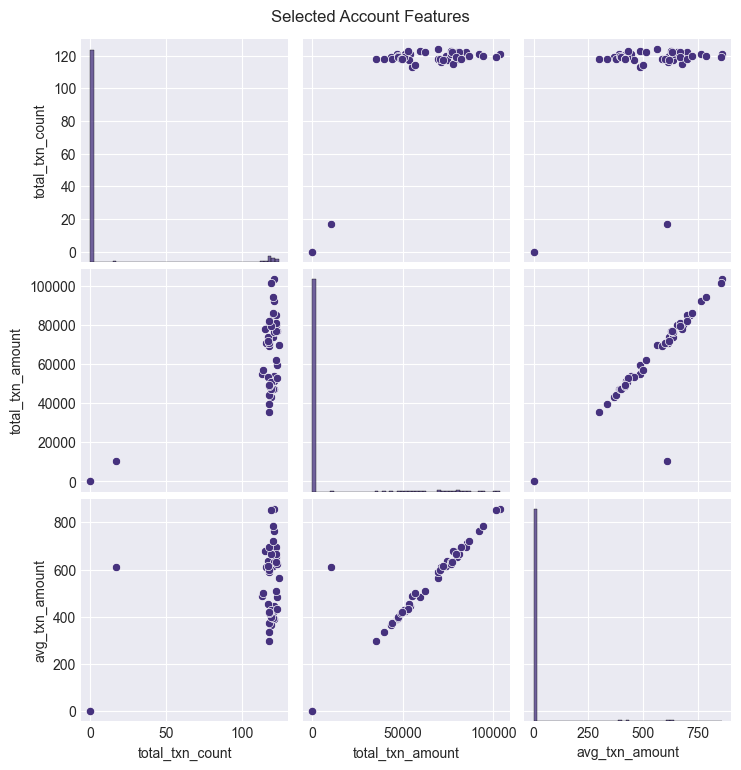

✅ Pair plot for Selected Account Features created.


<Figure size 1200x1200 with 0 Axes>

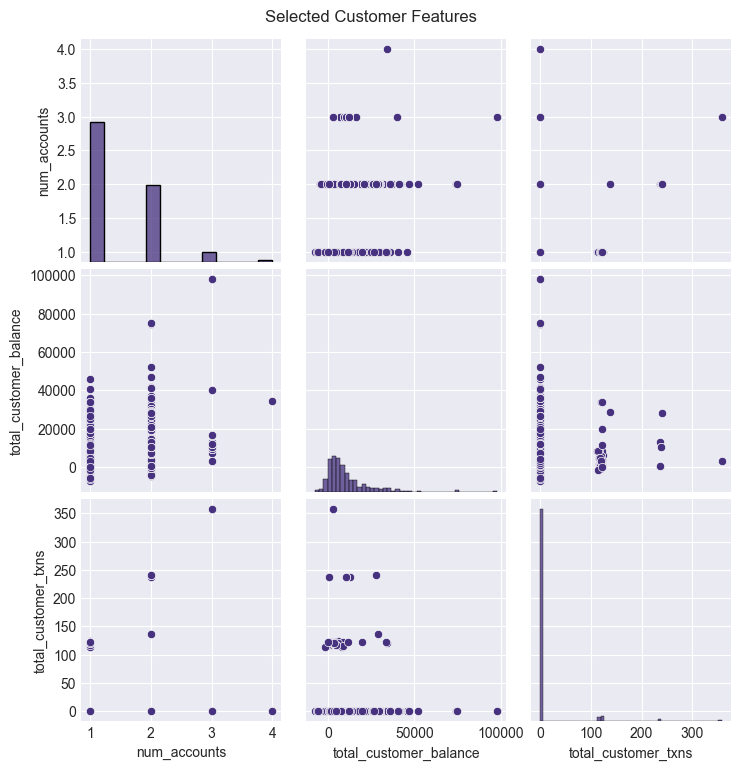

✅ Pair plot for Selected Customer Features created.

--- Comparing Groups with Box Plots ---


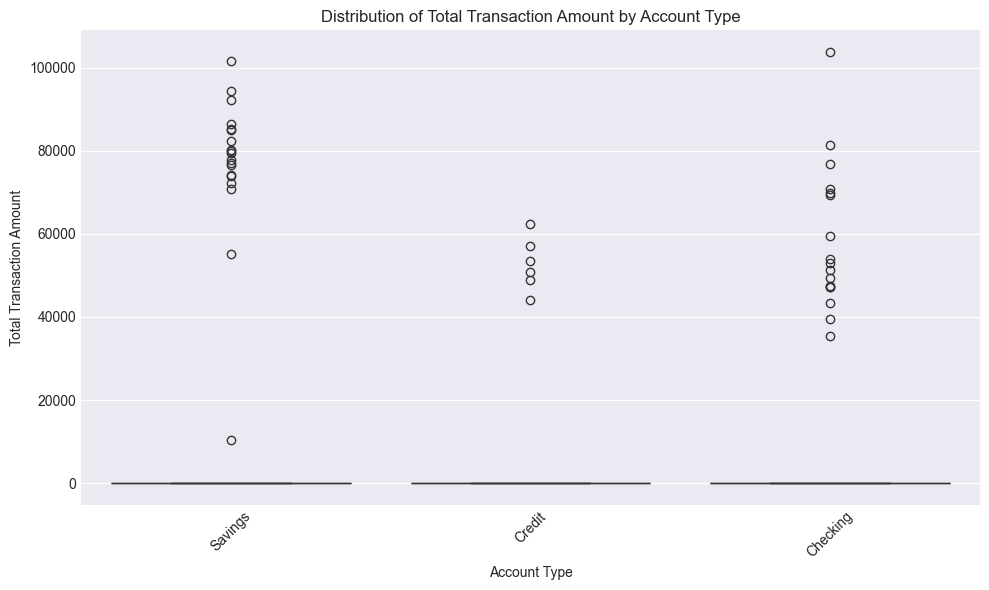

✅ Box plot comparing Total Txn Amount by Account Type created.
--------------------


In [9]:
# --- Relationship Visualizations ---
print("\n--- Creating Relationship Visualizations ---")

# --- Scatter Plots ---
def plot_scatter(df, x_col, y_col, title_suffix):
    """Helper to plot a scatter plot."""
    if x_col in df.columns and y_col in df.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=x_col, y=y_col, alpha=0.6)
        plt.title(f'Relationship: {x_col} vs {y_col} ({title_suffix})')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        # Optional: Add a trend line (commented out for speed)
        # sns.regplot(data=df, x=x_col, y=y_col, scatter=False, color='red', ax=plt.gca())
        plt.show()
        print(f"✅ Scatter plot for {x_col} vs {y_col} ({title_suffix}) created.")
    else:
        print(f"⚠️  Scatter plot columns {x_col}, {y_col} not found in DataFrame for {title_suffix}.")

# --- Account Level Scatter ---
if 'df_account_features_encoded' in locals() or 'df_account_features_encoded' in globals():
    plot_scatter(df_account_features_encoded, 'total_txn_amount', 'avg_txn_amount', 'Account Level')

# --- Customer Level Scatter ---
if 'df_customer_features_encoded' in locals() or 'df_customer_features_encoded' in globals():
    plot_scatter(df_customer_features_encoded, 'total_customer_balance', 'total_customer_txns', 'Customer Level')

# --- Pair Plots (use with caution on large datasets) ---
print("\n--- Creating Pair Plots (Sample) ---")
def plot_pairplot(df, features, title):
    """Helper to plot a pairplot for a subset of features."""
    if len(features) >= 2:
        # Limit data size for performance if necessary
        sample_df = df[features].dropna()
        if len(sample_df) > 5000: # Adjust threshold as needed
            print(f"     Sampling data for pairplot (N={len(sample_df)} -> 5000)...")
            sample_df = sample_df.sample(n=5000, random_state=42)
        
        if len(sample_df) > 1: # Ensure enough data after sampling/dropping NaNs
            plt.figure(figsize=(min(4 * len(features), 12), min(4 * len(features), 12))) # Dynamic size
            sns.pairplot(sample_df)
            plt.suptitle(title, y=1.02)
            plt.show()
            print(f"✅ Pair plot for {title} created.")
        else:
            print(f"⚠️  Insufficient data for pairplot: {title}")
    else:
        print(f"⚠️  Not enough features for pairplot: {title}")

# --- Pair Plot for Account Features ---
if 'df_account_features_encoded' in locals() or 'df_account_features_encoded' in globals():
    potential_pair_acc = ['total_txn_count', 'total_txn_amount', 'avg_txn_amount'] # Smaller set for pairplot
    pair_acc_features = [col for col in potential_pair_acc if col in df_account_features_encoded.columns]
    plot_pairplot(df_account_features_encoded, pair_acc_features, 'Selected Account Features')

# --- Pair Plot for Customer Features ---
if 'df_customer_features_encoded' in locals() or 'df_customer_features_encoded' in globals():
    potential_pair_cust = ['num_accounts', 'total_customer_balance', 'total_customer_txns']
    pair_cust_features = [col for col in potential_pair_cust if col in df_customer_features_encoded.columns]
    plot_pairplot(df_customer_features_encoded, pair_cust_features, 'Selected Customer Features')


# --- Box Plots for Comparing Groups ---
print("\n--- Comparing Groups with Box Plots ---")
# Use original DataFrames where categorical columns like 'account_type' still exist
# df_account_features was the one before one-hot encoding

if 'df_account_features' in locals() or 'df_account_features' in globals():
    if 'account_type' in df_account_features.columns and 'total_txn_amount' in df_account_features.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_account_features, x='account_type', y='total_txn_amount')
        plt.title('Distribution of Total Transaction Amount by Account Type')
        plt.xlabel('Account Type')
        plt.ylabel('Total Transaction Amount')
        # plt.yscale('log') # Uncomment if data is highly skewed
        plt.xticks(rotation=45) # Rotate labels if needed
        plt.tight_layout()
        plt.show()
        print("✅ Box plot comparing Total Txn Amount by Account Type created.")
    else:
        print("⚠️  Required columns ('account_type', 'total_txn_amount') not found in df_account_features for box plot.")
else:
    print("⚠️  df_account_features (pre-encoding) not found for group comparison box plot.")

# --- Correlation Heatmaps (already done in Cell 11, but can be reiterated if needed) ---
# The correlation heatmaps were already created in the previous step (Cell 11).
# If you want to re-display or modify them, you can add code here.
# For now, we'll consider that part complete.

print("-" * 20)


## Summary of Statistical Analysis & Visualization

This section provided a detailed statistical and visual exploration of the engineered features.

1.  **Statistical Summaries:** Comprehensive descriptive statistics (mean, std, percentiles) were generated for key numerical features at both account and customer levels. Skewness and Kurtosis were calculated using Pandas to understand the shape of the distributions, even without `scipy`.
2.  **Distributions:** Histograms with Kernel Density Estimation (KDE) were plotted for key features, revealing the underlying data distribution shapes (e.g., normal, skewed, bimodal).
3.  **Relationships:**
    *   Scatter plots illustrated potential linear or non-linear relationships between pairs of variables (e.g., Total Txn Amount vs Avg Txn Amount).
    *   Pair plots offered a multi-dimensional view of relationships among a small subset of features.
4.  **Group Comparisons:** Box plots compared numerical features (e.g., Total Txn Amount) across different categories (e.g., Account Type), highlighting differences in central tendency and spread.

These analyses are crucial for understanding the data, validating assumptions for potential modeling techniques, and communicating insights effectively. They fulfill the job requirement to "Generate statistical summaries, histograms, distributions, and correlations".